This notebook is intended to be an instructional guide to the Flips solver. At the moment, this is the primary source of documentation, which outlines the interface via example use-cases. Further questions may be sent via email (see the accompanying publication) or with the issue tracking system.

The first stage is to install the `flips` library via a `pip install flips`. Then we load the library once at the beginning of this notebook:

In [5]:
import flips
import matplotlib.pyplot as plt
import numpy as np

## 1. Simplest use-case
We consider the following reaction network:
\begin{align}
\emptyset \xrightarrow{b}X \xrightarrow{dX} \emptyset.
\end{align}

In the code we:<br>
**(1)** Define the reaction network. Note that the degradation is given only by its rate $d$ as mass action is implemented by default. All constants are dimensional. <br>
**(2)** Set initial conditions. Allowed arguments are `'uniform'` is a shorthand for uniform distribution, `'zero'` is to put all the density where all species counts are zero, and `'full'` puts all the density where species counts are maximal. For custom distributions, see the deidcated section <a href="#9.-Initial-distribution">*Initial distribution*</a> on how to easily obtain and populate an initial conditions array that matching the network discretisation. <br>
**(3)** Solve from $t=0$ up to some time, here $t=10$.<br>
**(4)** Plot the result at the final time.

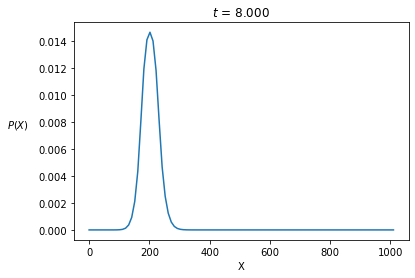

In [60]:
b = 200
d = 1

crn = flips.solver([
    [{}, {'X':1}, b],
    [{'X':1}, {}, d]
])

crn.set_initial_conditions('uniform')
crn.solve(8)
crn.plot_p()

The translation of the reaction network into code is as straightforward as it appears above. We provide a general description for the sake of clarity. Reaction networks are represented as a Python list. Each element of the list is a reaction, which is itself represented as a list with three elements: reactants, products, reaction rate. Reactants and products are dictionaries indexed by the species and of positive integer values representing the number of each species. Reaction rates may be scalars, which are interpreted as rate coefficients for mass action, or commonly implemented functions, such as Hill functions, as well as arbitrary functions with signature `(S, L, t)`, where `S` is populated by a dictionary of the state indexed by species, `L` is the system size parameter, and `t` is the time.

Various extensions are demonstrated below, including:<br>
**(1)** Production in bursts, whereby a product is created on a timescale faster than the one we resolve.
<br>
**(2)** The system may take discrete states, in each state the entire reaction network may be altered. Typically, only some reaction rates change.<br>
**(3)** Negative discrete reaction rates allow for 'phantom' discrete states that allow various auxiliary population-scale processes to be incorporated, for example, growth.<br>
**(4)** Arbitrary reaction rates, beyond classical mass action dynamics.

But before this, we explore other output we can seek from the solver.

Sometimes a more helpful tool is the interactive plot. This allows us to see the disctribution solution at various times (for further details on which time points are saved, see the section <a href="#11.-Saving-and-terminating">*Saving and terminating*</a>). The parameter `ylim` is optional, and keeps a constant upper limit for the y-axis. In its absence, the y-axis is rescaled at each frame which can hinder visual comparison.

In [61]:
crn.time_plot_p(ylim=.015)

interactive(children=(IntSlider(value=0, description='i', max=99), Output()), _dom_classes=('widget-interact',…

Plotting other statistical information is made easy too! Here are plots of the mean and standard deviation. For custom plots (or just generally to manipulate the data directly), you can access `crn.p_save` as described later.

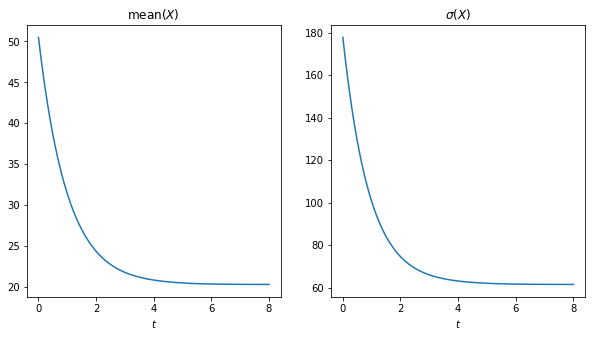

In [62]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
crn.plot_mean()
plt.subplot(1,2,2)
crn.plot_sigma()

## 2. Beyond mass action

In this example we simulate the reaction network given by
\begin{align}
\emptyset \xrightarrow{b X(\Omega-X)/\Omega^2} X \xrightarrow{d X} \emptyset,
\end{align}
where $\Omega$ is the system size.

The only difference in this example is that the reaction rate is now a function. Note that the function must accept three arguments: the state (a dictionary indexed by species), the system sizes (indexed by species), and the time. One important optimisation is to tell the system that the reaction rate is time-invariant. This saves a lot of time within the solver so makes execution faster. This is done by passing a function with a field `t` of value `False`, as in the example below.

In such functions, we use the scaled value of the state, defined by $x:=X/\Omega$. Therefore, $b X(\Omega-X)/\Omega^2=b x(1-x)$. The rate function accepts the scaled system state via the dictionary `S`, the system size `L` (which is shorter than `Omega`), and the time `t`. For time dependence, see the section <a href="#8.-Time-dependence">*Time dependence*</a>.

In [63]:
b = 3
d = 1
fn = lambda S,L,t: b*S['X']*(1-S['X'])
fn.t = False

crn = flips.solver([
    [{}, {'X':1}, fn],
    [{'X':1}, {}, d],
])#, scheme='first order')

crn.set_initial_conditions('full')
crn.solve(5)
crn.time_plot_p(ylim=.015)

interactive(children=(IntSlider(value=0, description='i', max=99), Output()), _dom_classes=('widget-interact',…

An equivalent way to obtain a time-invariant rate is to pass the function to the `flips.static_rate(...)` routine, as below.

In [36]:
fn = flips.static_rate(lambda S,L,t: b*S['X']*(1-S['X']))

Here is another example beyond mass-action: Hill kinetics for production while the species $X$ degrades when two entities come in contact:

\begin{align}
\emptyset \xrightarrow{\text{Hill}(5,1,1,0.1)} X \xrightarrow{d X(X-1)/2} \emptyset.
\end{align}
The Hill function is of the form
\begin{align}
\text{Hill}(X;n,K,\text{coeff},\text{shift}) = \text{shift} + \text{coeff} \frac{X^n}{K^n + X^n}.
\end{align}

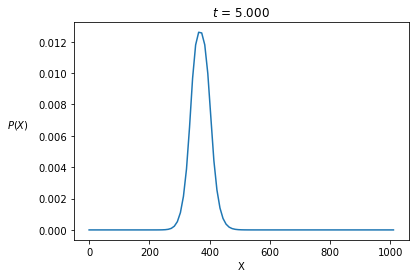

In [64]:
b = 100
d = 1
X_rctn_rate = lambda S,L,t:d*S['X']*(S['X']-1/L)/2
X_rctn_rate.t = False

crn = flips.solver([
    [{}, {'X':1}, flips.Hill('X',n=5,coeff=1,shift=.1)],
    [{'X':1}, {}, X_rctn_rate],
])

crn.set_initial_conditions('zero')
crn.solve(5)
crn.plot_p()

## 3. Bursty production
Bursty production of protein molecules (bursts occur with Poisson intensity $a$ and the geometric distribution of the burst size has parameter $b$), that degrades at a rate $d$
\begin{align}
\emptyset \xrightarrow{\text{burst}(a,b)} X \xrightarrow{d X} \emptyset
\end{align}

Notice the distinctly non-Gaussian steady state.

In [65]:
a = 2
b = 100
d = 1
crn = flips.solver([
    [{}, {'X':1}, flips.burst(a,b)],
    [{'X':1}, {}, d],
])

crn.set_initial_conditions('zero')
crn.solve(10)
crn.time_plot_p(ylim=.01)

interactive(children=(IntSlider(value=0, description='i', max=99), Output()), _dom_classes=('widget-interact',…

## 4. Multiple species

In this example, there are 2 species $X$ and $Y$, undergoing reactions:
\begin{align}
\emptyset \xrightarrow{\text{fn($X$)}} X \xrightarrow{c X} \emptyset, \\
X \xrightarrow{c X} Y \xrightarrow{c Y} X.
\end{align}
Notice how the default output is a two-dimensional contour plot!

In [71]:
b,c = 3,1
fn = lambda S,L,t: b*S['X']*(1-S['X'])
fn.t = False

crn = flips.solver([
    [{}, {'X':1}, fn],
    [{'X':1}, {'Y':1}, c],
    [{'X':1}, {}, c],
    [{'Y':1}, {'X':1}, c]
])

crn.set_initial_conditions('uniform')
crn.solve(7)
crn.time_plot_p()

interactive(children=(IntSlider(value=0, description='i', max=99), Output()), _dom_classes=('widget-interact',…

With multiple species, we might be interested in marginal distributions, such as those we plot below. Notice that these are obtained by calling the same plotting functions, where we pass the marginal species name as a first parameter.

In [67]:
crn.time_plot_p('X', ylim=[0,.015])

interactive(children=(IntSlider(value=0, description='i', max=99), Output()), _dom_classes=('widget-interact',…

In [68]:
crn.time_plot_p('Y', ylim=[0,.01])

interactive(children=(IntSlider(value=0, description='i', max=99), Output()), _dom_classes=('widget-interact',…

## 5. Hybrid CRNs
In this example, we consider the case where the system may exist in a discrete set of states, each dictating a different set of reactions. We take the discrete states to be the number of mRNA molecules, and in each state, proteins are produced with a rate proportional to the number of mRNA molecules. That is, we allow $M$ states, with state $0\leq m< M$ representing there being $m$ mRNA molecules. Protein $X$ is produced at a rate $bm$ for some constant $b$. We represent this graphically as
\begin{align}
\color{green}{
\emptyset \xrightarrow{a} m \xrightarrow{c m} \emptyset
}, \\
\emptyset \xrightarrow{b m} X \xrightarrow{d X} \emptyset,
\end{align}
where we have coloured the discrete state transitions green to distinguish it from the continuous state.

In [82]:
M = 3
b = 300
a = c = d = 1

crn = flips.solver([
    [{}, {'X':1}, lambda m:b*(m[0]+1)],
    [{'X':1}, {}, d],
], discrete_truncs={'m':M}, discrete_reactions=[
    [{}, {'m':1}, a],
    [{'m':1}, {}, lambda S:c*S['m']]
])

crn.set_initial_conditions('uniform')
crn.solve(5)
crn.time_plot_p(ylim=.006)

interactive(children=(IntSlider(value=0, description='i', max=99), Output()), _dom_classes=('widget-interact',…

In [84]:
crn.time_plot_p(state=[0], ylim=[0,.005])

interactive(children=(IntSlider(value=0, description='i', max=99), Output()), _dom_classes=('widget-interact',…

In [79]:
crn.time_plot_p(state=[1], ylim=[0,.005])

interactive(children=(IntSlider(value=0, description='i', max=99), Output()), _dom_classes=('widget-interact',…

In [80]:
crn.time_plot_p(state=[2], ylim=[0,.005])

interactive(children=(IntSlider(value=0, description='i', max=99), Output()), _dom_classes=('widget-interact',…

We must signal that we want to track $M=3$ states. Reactions in the network that do not change with the state (e.g. degradation of $X$ in the above example) remain the same in the code as well. Reactions whose rate changes with state (all three other reactions in the example above) are encoded by passing a function as the reaction rate. The function takes a single argument, the state index $0\leq m< M$, and returns a reaction rate just as it would be encoded regularly. The exception to this rule is any reaction that generates the discrete species, which will automatically be ignored when $m=M-1$. In the above example, we assume that no more $m$ can be produced when $m=M-1$ (since we are constructing a network with $M$ states of $m$), therefore the reaction rate should be `lambda m:a if m<M-1 else 0`, however this is taken care of automatically. For cases with user-defined reaction rates, this means passing a reaction rate that is a function that returns a function.

### 5.1 Discrete systems

Here is a quick example of a discrete-only system, which is essentially a classical CME (with the exact solution plotted as a dashed curve). The solver is not optimised for these systems, and therefore not expected to be particularly fast or accurate, however, it can be a useful benchmark or sanity test.

The network is:
\begin{align}
\color{green}{\emptyset \xrightarrow{b} X \xrightarrow{d X} \emptyset,}
\end{align}

where we consider only two states. The associated CME is given by

\begin{align}
\begin{pmatrix}
\dot p_0 \\
\dot p_1
\end{pmatrix}
= \begin{pmatrix}
-b & d \\ b & -d
\end{pmatrix}
\begin{pmatrix}
p_0 \\
p_1
\end{pmatrix},
\end{align}
which admits the solution $p_1 = 1-p_0$, where
\begin{align}
p_0(t) = p_0(0)\ \mathrm{e}^{-t(b + d)} + \frac 1{1+b/d}\ \left(1-\mathrm{e}^{-t(b + d)}\right).
\end{align}

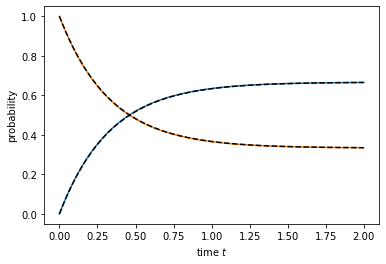

In [85]:
p0 = 0
b = 1
d = 2

crn = flips.solver(discrete_reactions=[
    [{}, {'X':1}, b],
    [{'X':1}, {}, d]
], discrete_truncs={'X':2}, step_frac=.01)

crn.set_initial_conditions([p0,1-p0])
crn.solve(2)
ts = [v[0] for v in crn.p_save]
ps = [v[1] for v in crn.p_save]
plt.plot(ts, [v[0] for v in ps])
plt.plot(ts, [v[1] for v in ps])
p0_fn = lambda t:p0*np.exp(-t*(b + d)) + 1/(1+b/d)*(1-np.exp(-t*(b + d)))
plt.plot(ts, [p0_fn(t) for t in ts], '--k')
plt.plot(ts, [1-p0_fn(t) for t in ts], '--k')
plt.xlabel('time $t$')
plt.ylabel('probability');

Note that we made the time step smaller by using the `step_frac` parameter. If left to the default value of `0.5`, a slight discrepancy is noticeable. For further details on the time stepping, see the section <a href="#12.-Time-stepping-and-solver-tuning">*Time-stepping and solver tuning*</a>.

## 6. Discretisation (lumping)

By default, `lump=10` molecules are lumped together in each finite volume cell with `num_lumps=100` such cells. These parameters may need to be varied for systems with different needs. The `lump` parameter is global, and must be shared across all continuum species which haveb the same resolution. However, the `num_lumps` parameter may be either global, in which case all species have the same finite domain, or may be specified per species. We demonstrate these changes on two-dimensional systems below.

In [8]:
def lump_crn(num_lumps=101, lump=10):
    plt.figure()
    crn = flips.solver([
       [{'AA':1}, {'B':1}, 1],
       [{'B':1}, {'AA':1}, .1],
    ], num_lumps=num_lumps, lump=lump)
    ics = crn.get_zero_initial_conditions()
    ics[0,:] = np.exp(-12*(np.linspace(0,1,ics.shape[1])-.5)**2)
    crn.set_initial_conditions(ics)
    crn.solve(30)
    crn.plot_p()

Keeping `num_lumps * lump` essentially constant preserves the domain of each species but changes the resolution. Note that the coarser the resolution the faster the simulation, but at the cost of accuracy

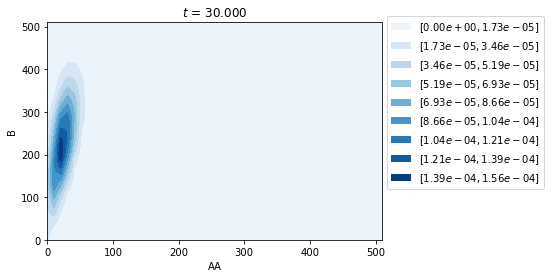

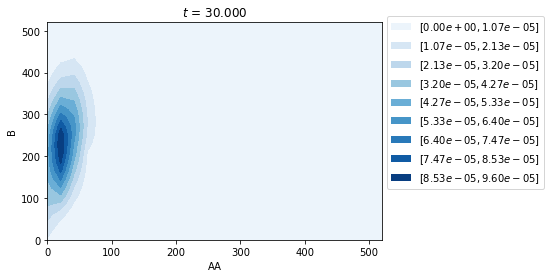

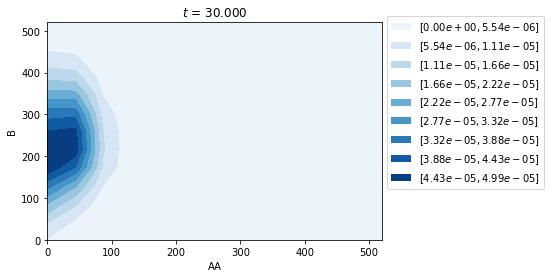

In [13]:
for lump in [10,20,40]:
    lump_crn(lump=lump, num_lumps=int(500/lump)+1)

We see from the above simulations that the `AA` species doesn't need a large domain, so we may contruct a smaller system by using fewer nodes for that species, while retaining the same resolution and thereby gaining huge computational speedup with little cost to accuracy

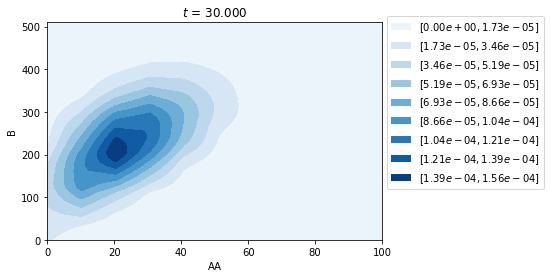

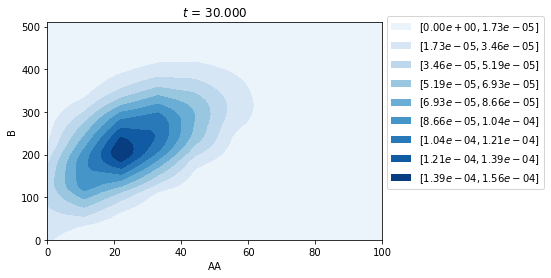

In [17]:
for num_lumps in [51,{'AA':11,'B':51}]:
    lump_crn(num_lumps=num_lumps, lump=10)
    plt.xlim(0,100)

## 7. General compartmental models

Here we simulate an SI compartmental epidemiological model, describing susceptible agents (S) that maye become infected upon contact with an infected agent (I), while infected agents recover over time. Using the default mass action kinetics, we write

\begin{align}
S + I &\xrightarrow{\beta S I} 2I, \\
I &\xrightarrow{\gamma I} \emptyset.
\end{align}

For the initial conditions, we start with the maximal number of susceptibles, and the smallest nonzero number of infections (for further details on setting initial conditions, see the section <a href="#9.-Initial-distribution">*Initial distribution*</a>). The mean results adopt the familiar SI forms. 

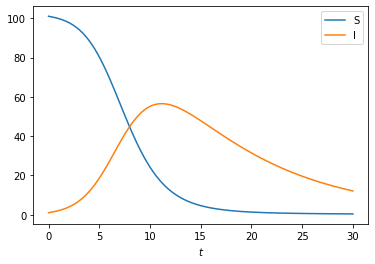

In [86]:
gamma = .1
beta = 1
crn = flips.solver([
    [{'S':1, 'I':1}, {'I':2}, beta],
    [{'I':1}, {}, gamma],
])

ics = crn.get_zero_initial_conditions()
ics[1,-1] = 1
crn.set_initial_conditions(ics)
crn.solve(30)
crn.plot_mean('S')
crn.plot_mean('I')
plt.legend(['S','I'])
plt.title('');

## 8. Time dependence

As mentioned above, time dependence is supported, but is very slow (even when the time-stepping is stretched beyond the guaranteed stability region with the `step_frac` parameter greater than one. For further details, see the section <a href="#12.-Time-stepping-and-solver-tuning">*Time-stepping and solver tuning*</a>). Notice how in this example the rate function is not passed to `flips.static_rate(...)` and its `t` attribute is not set, which signals to the solver that it is time-dependent. For further details, see the section <a href="#2.-Beyond-mass-action">*Beyond mass action*</a>.)

interactive(children=(IntSlider(value=0, description='i', max=99), Output()), _dom_classes=('widget-interact',…

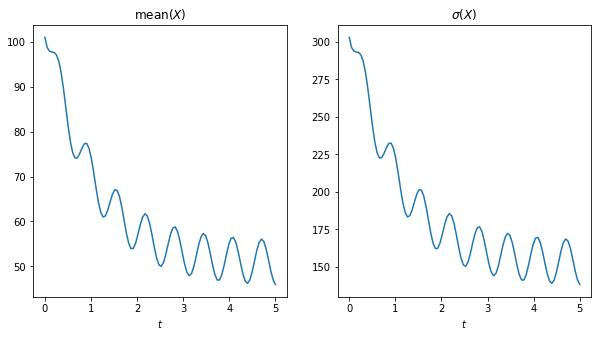

In [87]:
b = .5
d = 1

crn = flips.solver([
    [{}, {'X':1}, lambda S,L,t: (1+np.sin(10*t))*b],
    [{'X':1}, {}, d],
], step_factor=5)

crn.set_initial_conditions('full')
crn.solve(5)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
crn.plot_mean()
plt.subplot(1,2,2)
crn.plot_sigma()
crn.time_plot_p(ylim=.015)

When the time dependence is piecewise constant (that is, the time-varying values are actually constant over fixed intervals in time) we may exploit this structure by updating the internal representation at these known points in time, rather than at every time step. The way to tell the solver that the time-dependent function is piecewise constant is to set the `t` attribute of the rate function with a list of values at which the solver should update, as in the following example (recall that for time-independent rate functions, the `t` attribute is to be set to `False` and for general time-dependence a lambda function is passed with `t` evaluating to `True` and not a list of time points).

Note that the times listed in the `t` attribute influence the internal solver exclusively, but not the saving mechanism described by parameters `save` and `t_evals` (these are arguments for the `solve` function, while `t` is an attribute of a given reaction rate function). An example demonstrating this appears in section <a href="#11.-Saving-and-terminating">*Saving and terminating*</a>.

The following approximation reduces the runtime by at least two orders of magnitude, while restoring the time step to within the guaranteed stable range. Even though only an approximation, the suprising accuracy shows that it can be a useful tool.

interactive(children=(IntSlider(value=0, description='i', max=99), Output()), _dom_classes=('widget-interact',…

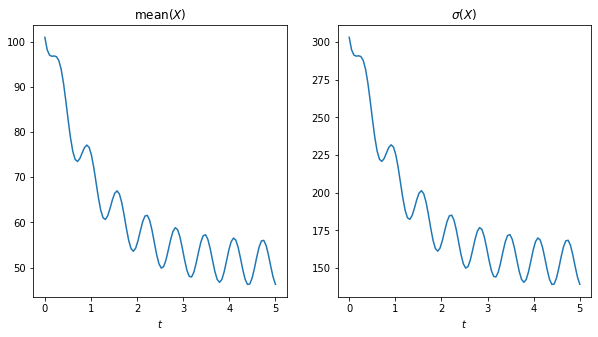

In [88]:
b = .5
d = 1
fn = lambda S,L,t: (1+np.sin(10*t))*b
fn.t = np.linspace(0,5,100).tolist()

crn = flips.solver([
    [{}, {'X':1}, fn],
    [{'X':1}, {}, d],
])

crn.set_initial_conditions('full')
crn.solve(5)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
crn.plot_mean()
plt.subplot(1,2,2)
crn.plot_sigma()
crn.time_plot_p(ylim=.015)

## 9. Initial distribution

The initial conditions may be set with convenient shorthands:

`crn.set_initial_conditions('uniform')` sets the uniform initial distribution, across all (continuum and discrete) species
`crn.set_initial_conditions('zero')` concentrates the initial distribution where all (continuum and discrete) species numbers at minimal (that is, zero)
`crn.set_initial_conditions('full')` concentrates the initial distribution where all (continuum and discrete) species numbers at maximal

You might want more fine-grained control of the initial conditions. The routine `crn.get_zero_initial_conditions()` provides a zero array of the correct structure which may be populated. There is a dimension for each species, with the order given by the return value of `crn.get_species()`, namely, the continuum species (arranged alphabetically) followed by the discrete species (arranged alphabetically). If this is a little imposing, you can populate the initial conditions by use of the helper function `crn.set_ics_value(ics, S, v)`, where `ics` is the array structure obtained above, `S` is a dictionary indexed by each species name and where the values are the index of each species, and `v` is the value for the associated density. This is demonstrated below. Note that the initial conditions are normalised internally, and so it suffices to provide the relative densities.

In [97]:
c = 1
num_lumps = {'X':50,'Y':55}

crn = flips.solver([
    [{}, {'X':1}, c],
    [{'X':1}, {'Y':1}, c],
    [{'X':1}, {}, c],
    [{'Y':1}, {'X':1}, c]
], num_lumps=num_lumps)

ics = crn.get_zero_initial_conditions()
print(f'Species: {crn.get_species()},  num_lumps = {num_lumps}, ics.shape = {ics.shape}')

# Make a rectangle for the initial conditions
Xs = [10,30]
Ys = [25,40]
for X in Xs:
    for Y in range(*Ys):
        crn.set_ics_value(ics, {'X':X,'Y':Y}, X*Y)
for Y in Ys:
    for X in range(*Xs):
        crn.set_ics_value(ics, {'X':X,'Y':Y}, X*Y)
crn.set_initial_conditions(ics)
crn.solve(.01, save=2)
crn.time_plot_p()

Species: ['X', 'Y'],  num_lumps = {'X': 50, 'Y': 55}, ics.shape = (50, 55)


interactive(children=(IntSlider(value=0, description='i', max=1), Output()), _dom_classes=('widget-interact',)…

## 10. Accessing the results

As demonstrated above, there are routines to plot the solution in one and two dimensions: `plot_p`. You might be interested to probe the values, or post-process them manually. The saved densities are in the list `crn.p_save`. Each element is a tuple of the form `(t,p)` indicating the time point and the matrix of densities, respectively. The matrix `p` has the same structure as the initial conditions described above, that is, it has dimensions for each species, the order may be accessed by `crn.get_species()`, which is the continuum species (arranged alphabetically) followed by the discrete species (arranged alphabetically).

If the structure of `p` seems complex, we provide the access function `crn.get_prob_dens(i, S)` that allow you to specify a time index `i` and dictionary with indices for each species, and we return the value, as demonstrated below. The saved times may be easily access via `crn.get_saved_times()`.

In [38]:
c = 1
num_lumps = {'X':50,'Y':55}

crn = flips.solver([
    [{}, {'X':1}, c],
    [{'X':1}, {'Y':1}, c],
    [{'X':1}, {}, c],
    [{'Y':1}, {'X':1}, c]
], num_lumps=num_lumps)

crn.set_initial_conditions('uniform')
crn.solve(1, save=5)

Saved times = [0, 0.25, 0.5, 0.75, 1], len(crn.p_save) = 5
Species: ['X', 'Y'],  num_lumps = {'X': 50, 'Y': 55}, crn.p_save[3][1].shape = (50, 55)
crn.p_save[3][1][15,10] = 9.940200531862115e-06 = 9.940200531862115e-06 = crn.get_prob_dens(3,{'X':15,'Y':10})


In [39]:
print(f'Saved times = {crn.get_saved_times()}, len(crn.p_save) = {len(crn.p_save)}')
i = 3
p = crn.p_save[i][1]
print(f'Species: {crn.get_species()},  num_lumps = {num_lumps}, crn.p_save[{i}][1].shape = {p.shape}')
X,Y = 15,10
S = {'X':X,'Y':Y}
print(f'crn.p_save[{i}][1][{X},{Y}] = {p[X,Y]} = {crn.get_prob_dens(i,S)} = crn.get_prob_dens({i},{{\'X\':{X},\'Y\':{Y}}})')

Saved times = [0, 0.25, 0.5, 0.75, 1], len(crn.p_save) = 5
Species: ['X', 'Y'],  num_lumps = {'X': 50, 'Y': 55}, crn.p_save[3][1].shape = (50, 55)
crn.p_save[3][1][15,10] = 9.940200531862115e-06 = 9.940200531862115e-06 = crn.get_prob_dens(3,{'X':15,'Y':10})


## 11. Saving and terminating

For each solve, some terminal condition is required to know when to stop calculating. In most cases, this will just be at some predetermined time `T`. Another option is to stop when a customisable event occurs, which is done by passing a function with the signature `lambda p,t: ...`, which returns `False` as long as the simulation should keep going, and `True` once the terminating condition has been met. `p` is the probability density matrix and `t` is the current time. The structure of `p` is described above (sections <a href="#9.-Initial-distribution">*Initial distribution*</a> and <a href="#10.-Accessing-the-results">*Accessing the results*</a>) since the structure of the intermediate probability is identical to the initial conditions and final results. The helper function here is called `crn.S2ij(S)` and takes a dictionary indexing each species, as above.

There are two options to tell the solver which frames of the solution to save. The first is to provide a number of frames `crn.solve(T, save=100)` saves `100` frames. Alternatively, you might be interested in specific times, in which case a list may be passed `crn.solve(T, save=[0,T/6,T*5/6,T])`. When passing a terminal event, since the final time is not known in advance, a list must be passed, and all times in the list that occur before the terminal event are saved.

The options are summarised in the flowchart below the example.

In [98]:
b = 200
d = 1

crn = flips.solver([
    [{}, {'X':1}, b],
    [{'X':1}, {}, d]
])

crn.set_initial_conditions('uniform')
def terminate(p,t):
    return p[crn.S2ij({'X':20})] > .01 or t > 10
crn.solve(terminate, save=np.linspace(0,5,100))
crn.time_plot_p(ylim=.015)

interactive(children=(IntSlider(value=0, description='i', max=52), Output()), _dom_classes=('widget-interact',…

After some calculations, you can simulate the same network for more time (starting from where the previous simulation ended). Setting the initial conditions resets the time back to zero, and erases previous simulation results. Note that the time difference between adjacent frames might be different for each interval over which you solve, as is the case if we continue from the previous example:

In [99]:
crn.solve(5)
crn.time_plot_p(ylim=.015)

interactive(children=(IntSlider(value=0, description='i', max=151), Output()), _dom_classes=('widget-interact'…

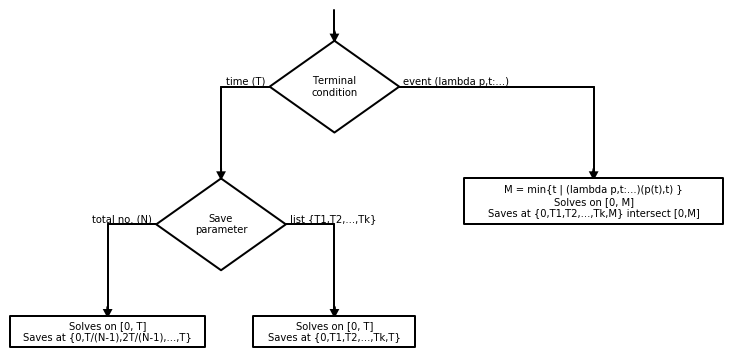

In [3]:
import schemdraw
from schemdraw import flow
d = schemdraw.Drawing(fontsize=10)
d.add(flow.Arrow('down', l=d.unit/3))
dT = d.add(flow.Decision(w=4, h=3, W='time (T)', E='event (lambda p,t:...)', label='Terminal\ncondition'))
d.add(flow.Line('left', xy=dT.W, l=d.unit/2))
d.add(flow.Arrow('down', l=d.unit))
dS = d.add(flow.Decision(w=4, h=3, W='total no. (N)', E='list {T1,T2,...,Tk}', label='Save\nparameter'))
d.add(flow.Line('left', xy=dS.W, l=d.unit/2))
d.add(flow.Arrow('down', l=d.unit))
d.add(flow.Box(w=6, h=1, label='Solves on [0, T]\nSaves at {0,T/(N-1),2T/(N-1),...,T}'))

d.add(flow.Line('right', xy=dS.E, l=d.unit/2))
d.add(flow.Arrow('down', l=d.unit))
d.add(flow.Box(w=5, h=1, label='Solves on [0, T]\nSaves at {0,T1,T2,...,Tk,T}'))

d.add(flow.Line('right', xy=dT.E, l=d.unit*2))
d.add(flow.Arrow('down', l=d.unit))
d.add(flow.Box(w=8, h=1.5, label='M = min{t | (lambda p,t:...)(p(t),t) }\nSolves on [0, M]\nSaves at {0,T1,T2,...,Tk,M} intersect [0,M]'))
d.draw()

As mentioned in setcion *Time dependence*, a piecewise-constant rate function has time points at which the solver updates, however, these are not saved by default, as demonstrated in the example below, where the `save` parameters describes the time points (other than the endpoints) to save, the `t_evals` parameter may augment these values, but the `t` attribute of the rate function has no influence.

In [43]:
c = 1
fn = lambda S,L,t: b * (int(np.round(t)) % 2)
fn.t = [1,2,3,4]

crn = flips.solver([
    [{}, {'X':1}, fn],
    [{'X':1}, {}, c],
])

crn.set_initial_conditions('full')
crn.solve(5, t_evals=[.01,.02,.03], save=10)
ts1 = ' '.join([f'{frame[0]:.2f}' for frame in crn.p_save])

crn.set_initial_conditions('full')
crn.solve(5, save=[.01,.02,.03])
ts2 = ' '.join([f'{frame[0]:.2f}' for frame in crn.p_save])

print('ts1 =', ts1)
print('ts2 =', ts2)

ts1 = 0.00 0.01 0.02 0.03 0.56 1.11 1.67 2.22 2.78 3.33 3.89 4.44 5.00
ts2 = 0.00 0.01 0.02 0.03 5.00


## 12. Time-stepping and solver tuning

In this section, we explore how changing the time step and discretisation change the simulation results. To this end, we define a function that solves the system described in the section <a href="#1.-Simplest-use-case">*Simplest use-case*</a>, where we provide two additional arguments to the solver: `step_frac` and `scheme`. In the accompanying publication we show that the Euler and KT schemes are guaranteed to be monotonic when the time-step $\Delta t\leq \text{CFL}$ is bounded by some function of the system parameters (and possibly time). The actual time step we choose to take is $\Delta t= \text{step_frac}\times\text{CFL}$. In general, keeping `step_frac` below one guarantees the condition is satisfied (the default is `0.5`). However, in practice, especially when testing or doing back-of-the-envelope simulations, one may take larger steps before running into trouble. Below we demonstrate how the simulation results appear indistinguishable for `step_frac` up to approximately 7.3, beyond which unstable oscillations dominate the solution.

Almost all of the previous examples used the default `step_frac` value, however, these could all have been sped up, sometimes significantly, with much larger `step_frac` values, and little loss of accuracy.

In [58]:
def solve_tuned(step_frac=0.5, scheme='KT'):
    b = 200
    d = 1

    crn = flips.solver([
        [{}, {'X':1}, b],
        [{'X':1}, {}, d]
    ], step_frac=step_frac, scheme=scheme)

    crn.set_initial_conditions('uniform')
    crn.solve(5)
    crn.plot_p()

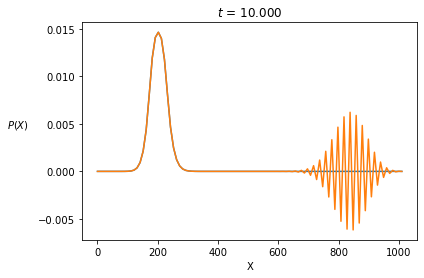

In [72]:
for step_frac in [0.5,7.31]:
    solve_tuned(step_frac=step_frac)

Below, we show how a classical first-order finite-difference scheme suffers from the well-known issue of extra numerical diffusivity. Nonetheless, the computation is very fast, and thus may be a useful tool.

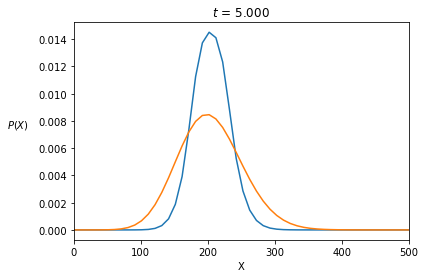

In [59]:
for scheme in ['KT','first order']:
    solve_tuned(scheme=scheme)
plt.xlim(0,500);

The time-stepping method and order may also be changed, as demonstrated below (see the accompanying publication for further details and references).

In [92]:
b = 200
d = 1

def solve_tuned(stepper='RK', step_order=2, step_level=3):
    crn = flips.solver([
        [{}, {'X':1}, b],
        [{'X':1}, {}, d]
    ], stepper=stepper, step_order=step_order, step_level=step_level)

    crn.set_initial_conditions('uniform')
    crn.solve(5)
    crn.plot_p()

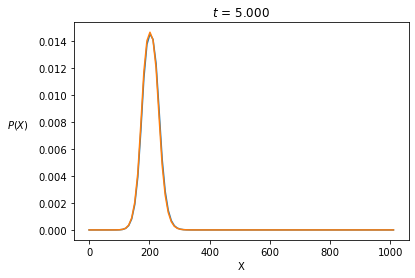

In [93]:
for stepper in ['RK', 'multilevel']:
    solve_tuned(stepper=stepper)

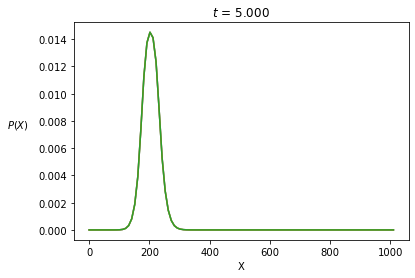

In [95]:
for step_order in [1,2,3]:
    solve_tuned(stepper='RK', step_order=step_order)

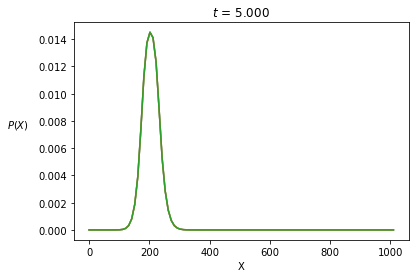

In [96]:
for step_level in [3,4,5]:
    solve_tuned(stepper='RK', step_order=3, step_level=step_level)

## 13. Cautionary tales

### 13.1 Absorbing states

In the birth-death example, absorption at zero doesn't occur naturally. Strictly speaking, this violates the continuum assumption, but that's not necessarily the cause, since using the first-order scheme shows that there is absorption.

In [33]:
b = 1.2
d = 1
fn = lambda S,L,t: b*S['X']*(1-S['X'])
fn.t = False

crn = flips.solver([
    [{}, {'X':1}, fn],
    [{'X':1}, {}, d],
], step_frac=3) #, scheme='first order')

crn.set_initial_conditions('full')
crn.solve(500)
crn.time_plot_p(ylim=.015)

interactive(children=(IntSlider(value=0, description='i'), Output()), _dom_classes=('widget-interact',))

But, this seems to be remedied, at least qualitatively, by making an extra state also absorbing

In [34]:
b = 1.2
d = 1
fn = lambda S,L,t: b*S['X']*(1-S['X']) if S['X']>.01 else 0
fn.t = False

crn = flips.solver([
    [{}, {'X':1}, fn],
    [{'X':1}, {}, d],
], step_frac=3)

crn.set_initial_conditions('full')
crn.solve(500)
crn.time_plot_p(ylim=.015)

interactive(children=(IntSlider(value=0, description='i'), Output()), _dom_classes=('widget-interact',))

### 13.2 Reaction with multiple molecules of a species

Consider a system of reactions described by
\begin{align}
2A \xrightarrow{A^2} B \xrightarrow{c B} 2A.
\end{align}
When encoding this straightforwardly, the results appear rather peculiar.

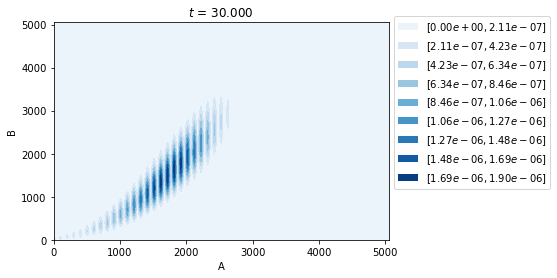

In [45]:
N = 101
c = 0.1
ics = np.zeros((N,N))
ics[0,:] = np.exp(-12*(np.linspace(0,1,N)-.5)**2)
crn = flips.solver([
   [{'A':2}, {'B':1}, 1],
   [{'B':1}, {'A':2}, c],
], num_lumps=N, lump=50, L=10000)
crn.set_initial_conditions(ics)
crn.solve(30)
crn.plot_p()

The reason is because the species `A` only ever appears in pairs, and since the initial condition contains only the species `B`, `A` is always even, hence the stripes of zero probability for odd values of `A`. There are several ways to resolve this issue. The results can be used as they are with odd values of `A` interpolated or simply ignored. When other reactions violate this parity the shuttering effect is less noticeable due to even small amounts of diffusion. For example, if the system also undergoes

\begin{align}
A \xrightarrow{dA} \emptyset.
\end{align}

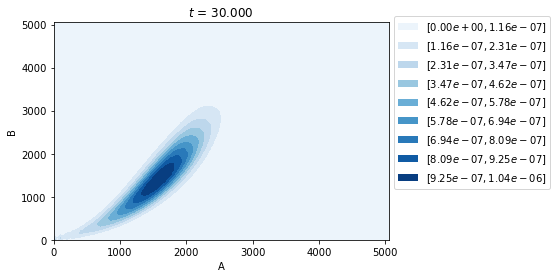

In [47]:
N = 101
c = 0.1
ics = np.zeros((N,N))
ics[0,:] = np.exp(-12*(np.linspace(0,1,N)-.5)**2)
crn = flips.solver([
   [{'A':2}, {'B':1}, 1],
   [{'B':1}, {'A':2}, c],
   [{'A':1}, {}, c**2],
], num_lumps=N, lump=50, L=10000)
crn.set_initial_conditions(ics)
crn.solve(30)
crn.plot_p()

When no other reactions change the parity, then the system may be modeled by 'pairs' of `A` molecules, which we denote by the abstract species `AA` (they need not be physically paired). In the continuum approximation this smoothing out of odd numbers of molecules (for example, in an initial condition) into even numbers is a minor approximation. The system may then be written as
\begin{align}
AA \xrightarrow{AA^2/4} B \xrightarrow{c B} AA.
\end{align}

Remember that, while the plot appears to show vastly different results, the quantities `AA` and `A` do not represent the same thing, therefore the initial conditions are not equivalent.

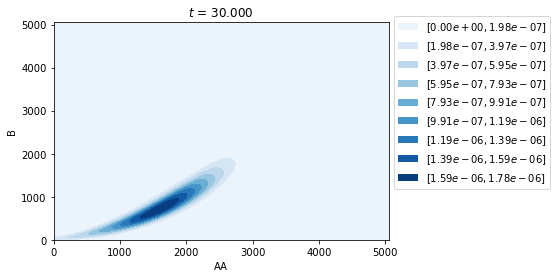

In [50]:
N = 101
c = 0.1
ics = np.zeros((N,N))
ics[0,:] = np.exp(-12*(np.linspace(0,1,N)-.5)**2)
crn = flips.solver([
   [{'AA':1}, {'B':1}, flips.static_rate(lambda S,L,t: S['AA']**2/4)],
   [{'B':1}, {'AA':1}, c],
], num_lumps=N, lump=50, L=10000)
crn.set_initial_conditions(ics)
crn.solve(30)
crn.plot_p()